<a href="https://colab.research.google.com/github/mariell-morven/Riesgo_Relativo/blob/main/Riesgo_Relativo_1_Detecci%C3%B3n_de_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importación de librerías,
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import google.colab.data_table as dt

# & paquetes
from google.cloud import bigquery
from google.colab import auth
from scipy import stats

In [ ]:
# Autenticación
auth.authenticate_user()

# BigQuery
project_id = 'proyecto-no3-riesgos'
client = bigquery.Client(project=project_id)

# Original
Uníon de tablas con sus valores originales



In [ ]:
# Query SQL
query = """
SELECT * EXCEPT (user_id)
FROM proyecto-no3-riesgos.dataset.original
"""

# Ejecutar la consulta en BigQuery y obtener los resultados
query_job = client.query(query)
original = query_job.to_dataframe()

In [ ]:
# Estructura: filas y columnas
original.shape

(36000, 12)

In [ ]:
# Valores no nulos, tipo de dato de cada columna y el uso de memoria
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   age                                           36000 non-null  Int64  
 1   number_dependents                             35057 non-null  Int64  
 2   latest_salary                                 28801 non-null  Int64  
 3   total_loans                                   35575 non-null  Int64  
 4   real_estate                                   35575 non-null  Int64  
 5   others                                        35575 non-null  Int64  
 6   more_90_days_overdue                          36000 non-null  Int64  
 7   using_lines_not_secured_personal_assets       36000 non-null  float64
 8   number_times_delayed_payment_loan_30_59_days  36000 non-null  Int64  
 9   debt_ratio                                    36000 non-null 

Medidas de Tendencia Central y de Dispersión:

In [ ]:
# Resumen estadístico: distribución y variabilidad
original.describe()

,age,number_dependents,latest_salary,total_loans,real_estate,others,more_90_days_overdue,using_lines_not_secured_personal_assets,number_times_delayed_payment_loan_30_59_days,debt_ratio,number_times_delayed_payment_loan_60_89_days,default_flag
count,36000.0,35057.0,28801.0,35575.0,35575.0,35575.0,36000.0,36000.000000,36000.0,36000.000000,36000.0,36000.0
mean,52.417417,0.75808,6675.052047,8.582853,1.027744,7.555109,0.260806,5.807040,0.419278,351.580075,0.237861,0.018972
std,14.791331,1.118739,12961.778477,5.127896,1.119468,4.758217,4.121365,223.407144,4.14402,2011.635341,4.105515,0.136429
min,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,41.0,0.0,3400.0,5.0,0.0,4.0,0.0,0.029526,0.0,0.176265,0.0,0.0
50%,52.0,0.0,5400.0,8.0,1.0,7.0,0.0,0.149655,0.0,0.366169,0.0,0.0
75%,63.0,1.0,8300.0,11.0,2.0,10.0,0.0,0.548529,0.0,0.873552,0.0,0.0
max,109.0,13.0,1560100.0,57.0,25.0,56.0,98.0,22000.000000,98.0,307001.000000,98.0,1.0


> El último cuartil de la mayoría de las variables parece presentar una gran variabilidad.

In [ ]:
# Calcular valores estadísticos
summary = original.agg(['mean', 'median', 'std'])

# Redondear los resultados a 3 decimales
summary = summary.round(3)

dt.DataTable(summary)

,age,number_dependents,latest_salary,total_loans,real_estate,others,more_90_days_overdue,using_lines_not_secured_personal_assets,number_times_delayed_payment_loan_30_59_days,debt_ratio,number_times_delayed_payment_loan_60_89_days,default_flag
mean,52.417,0.758,6675.052,8.583,1.028,7.555,0.261,5.807,0.419,351.580,0.238,0.019
median,52.000,0.000,5400.000,8.000,1.000,7.000,0.000,0.150,0.000,0.366,0.000,0.000
std,14.791,1.119,12961.778,5.128,1.119,4.758,4.121,223.407,4.144,2011.635,4.106,0.136


Multicolinealidad:

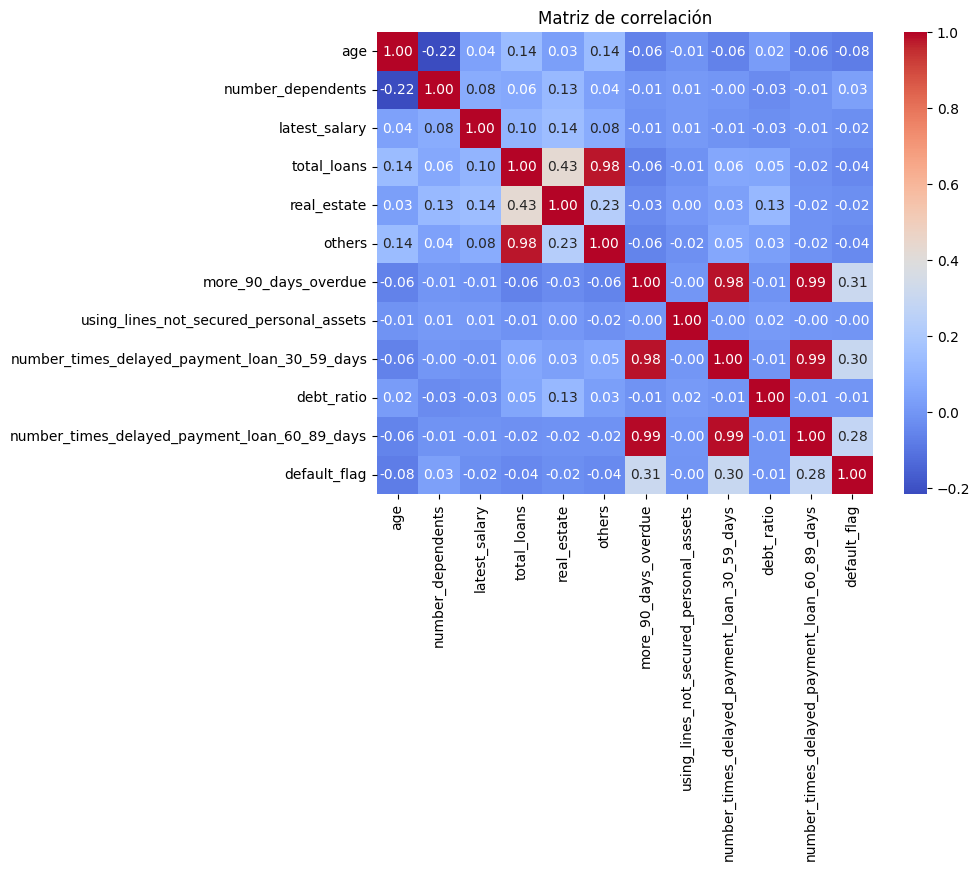

In [ ]:
# Matriz de Correlación
correlation_matrix = original.corr()

# Visualizar la matriz de correlación usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

Selección de Variables:

**Género**
> Variable "sex" no es considerada en este estudio buscando evitar discriminación por género.

(https://docs.google.com/document/d/1ETSC6MM4jeIEQZSxvX_jlFnzta2i4-XiWtpNyyLTh5E/)


**Tiempo**
> La alta correlación entre las variables de tiempo: number_times_delayed_payment_loan_30_59_days, number_times_delayed_payment_loan_60_89_days, y more_90_days_overdue, indica multicolinealidad.

> De acuerdo con la desviación estándar más alta la variable más representativa sería number_times_delayed_payment_loan_30_59_days, sin embargo dada las hipotésis se eligió more_90_days_overdue.



## Detección de valores atípicos, extremos e inconsistencias


**Tiempo** (more_90_days_overdue)
>  Considerando el valor de la variable como el "número de veces que el cliente estuvo más de 90 días vencido," la data presenta inconsitencias al tener 1 registro con un valor de 96 y 62 más con 98, es decir, un atraso de alrededor de 24 años, lo cual no puede ser posible al tener dentro de ese grupo usuarios con una edad de 21 años.

> Aunado a lo anterior, estos mismos valores se presentan en las demás variables por lo que se decidió imputar al valor máximo posible, 15, en vez de la mediana.
---
Total de inconsitencias (y modificaciones): 63

**Edad**

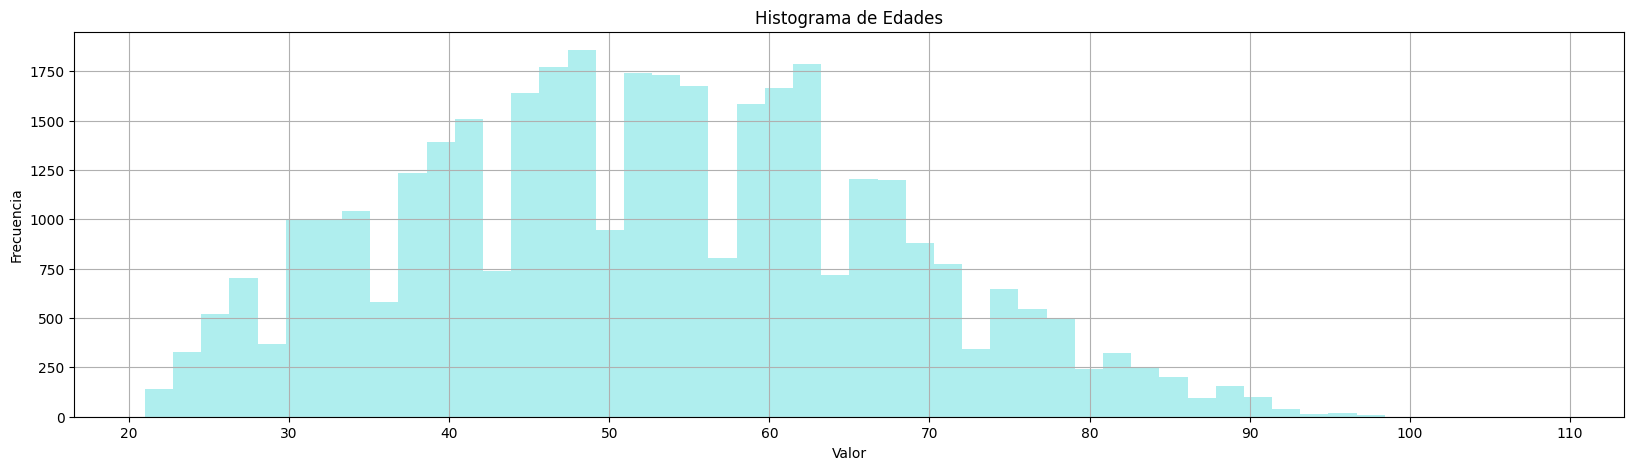

In [ ]:
plt.figure(figsize=(20, 5))
plt.hist(original['age'], bins=50, color='paleturquoise')
plt.title("Histograma de Edades")
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.locator_params(axis='x', nbins=10)

plt.show()

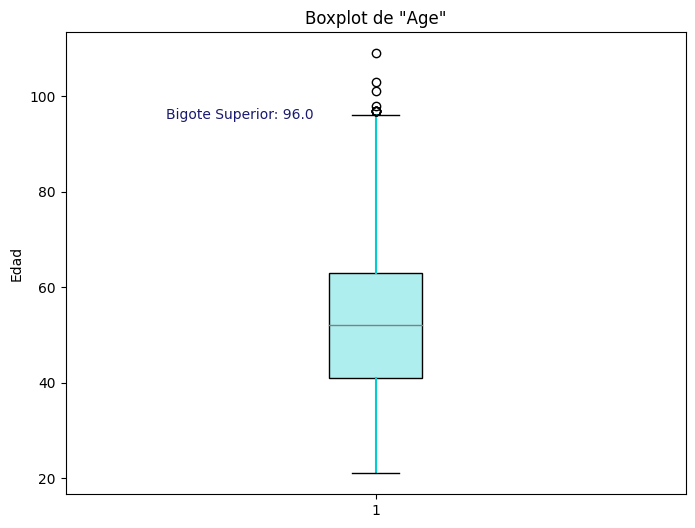

In [ ]:
# Calcular medidas estadísticas
q1 = np.percentile(original['age'], 25)
q3 = np.percentile(original['age'], 75)

# Calcular el rango intercuartílico (IQR)
iqr = q3 - q1

# Calcular el extremo del bigote superior
upper_whisker = q3 + 1.5 * iqr

plt.figure(figsize=(8, 6))
box = plt.boxplot(original['age'], patch_artist=True, boxprops=dict(facecolor='paleturquoise'), medianprops=dict(color='gray'))
plt.title('Boxplot de "Age"')
plt.ylabel('Edad')
for whisker in box['whiskers']:
    whisker.set(color='darkturquoise', linewidth=1.5)

# Mostrar el valor del extremo del bigote superior
plt.text(0.90, upper_whisker, f'Bigote Superior: {upper_whisker}', ha='right', va='center', color='midnightblue')

plt.show()

> El valor máximo de edad considerado en este estudio, entre la visualización de la distribución, la expectativa de vida* y el posible uso posterior del modelo, se establecío hasta los 99 años.

*Suponiendo que la data pertenece al país de EUA, dado la moneda y la edad de 21 años como mínima presente
(https://www.cdc.gov/nchs/fastats/life-expectancy.htm)

---
Total de valores atípicos (edad > 99 años): 3 usuarios


**Líneas de crédito** & **Ratio de Deuda**
> Todos los valores mayores a 0.99 de las variables using_lines_not_secured_personal_assets y debt_ratio fueron imputadas a 1. Dado que el valor máximo esperado de la relación no debería sobrepasar dicho número, hecho que indica un sobre-endeudamiento.
---
Total de modificaciones: 780 y 8461, respectivamente.

**Salario**

Previamente se modifico el tipo de data de la variable "last_month_salary" de FLOAT a INTEGER para evitar la pérdida de precisión, o significancia.

(https://stackoverflow.com/questions/3730019/why-not-use-double-or-float-to-represent-currency)

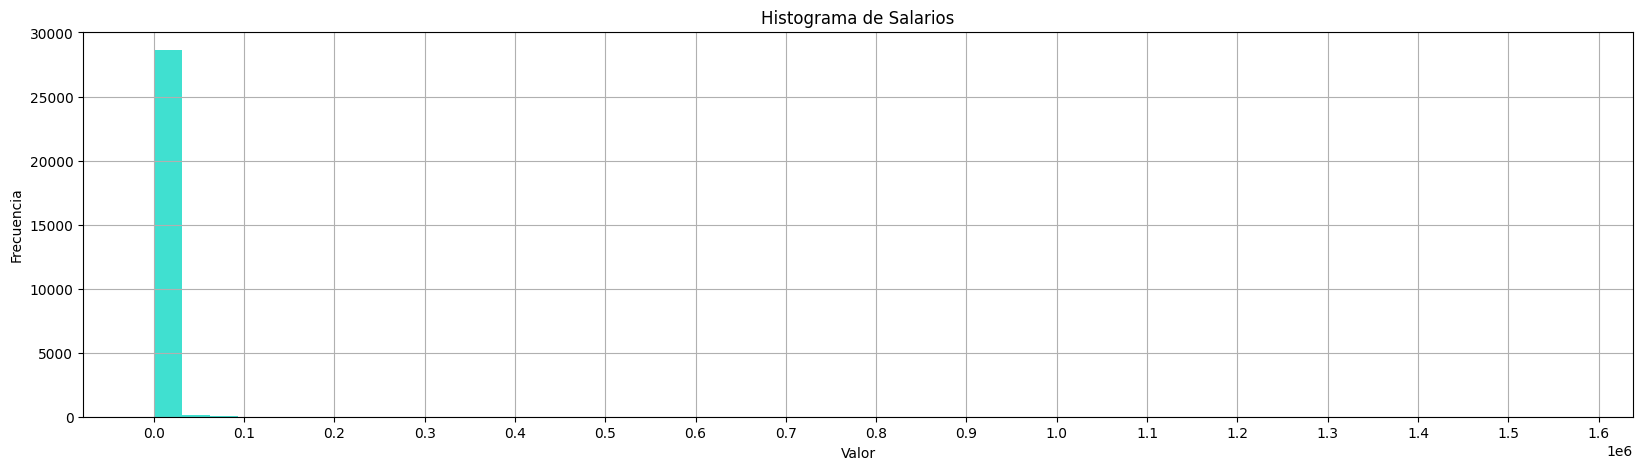

In [ ]:
salary_value = original['latest_salary'].dropna() # Eliminar valores NaN (nulos)

plt.figure(figsize=(20, 5))
plt.hist(salary_value, bins=50, color='turquoise')
plt.title("Histograma de Salarios")
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.locator_params(axis='x', nbins=20)

plt.show()

> Dispersión tan grande en los máximos valores que no se logra apreciar la distribución

In [ ]:
# Test de Shapiro-Wilk
statistic, p_value = stats.shapiro(original['latest_salary'].dropna())

# Mostrar los resultados
print(f"Estadística de prueba: {statistic}")
print(f"Valor p: {p_value}")

alpha = 0.05  # Nivel de significancia

if p_value > alpha:
    print("No se rechaza la hipótesis nula: los datos podrían provenir de una distribución normal.")
else:
    print("Se rechaza la hipótesis nula: los datos no provienen de una distribución normal.")

Estadística de prueba: 0.1594531536102295
Valor p: 0.0
Se rechaza la hipótesis nula: los datos no provienen de una distribución normal.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# Calculo de mediana
mediana_salary = original['latest_salary'].median()

print(f"Mediana original de la variable 'Last Month Salary': {mediana_salary}")

Mediana original de la variable 'Last Month Salary': 5400.0


In [ ]:
# Z-score
salary_values = original['latest_salary'].dropna() # Eliminar valores NaN: nulos
median_salary = np.median(salary_values) # Mediana
mad_salary = 1.4826 * np.median(np.abs(salary_values - median_salary)) # MAD: Median Absolute Deviation

original['salary_zscore'] = (original['latest_salary'] - median_salary) / mad_salary #Zscore

# Reemplazar los valores NaN en 'salary_zscore' con un valor predeterminado (por ejemplo, 0)
original['salary_zscore'] = original['salary_zscore'].fillna(0)

# Identificación de outliers a ±7.5 MADs de la mediana
original["is_outlier"] = np.where(
    (original['salary_zscore'] <= -7.5) | (original['salary_zscore'] >= 7.5),
    True,
    False
)

> Valor ±7.5 seleccionado en busca de conservar la muestra de malos pagadores (valor máx: 28,000) y usuarios jóvenes (dada las hipótesis)

In [ ]:
original['salary_zscore'].describe()

count       36000.0
mean        0.29278
std        3.330762
min       -1.549894
25%       -0.430526
50%             0.0
75%        0.578627
max      446.225865
Name: salary_zscore, dtype: Float64

In [ ]:
# Outliers encontrados
original.loc[original["is_outlier"]==True]

,age,number_dependents,latest_salary,total_loans,real_estate,others,more_90_days_overdue,using_lines_not_secured_personal_assets,number_times_delayed_payment_loan_30_59_days,debt_ratio,number_times_delayed_payment_loan_60_89_days,default_flag,salary_zscore,is_outlier
358,58,0,44514,<NA>,<NA>,<NA>,0,1.000000,0,0.000000,0,0,11.226396,True
564,68,1,62500,1,0,1,0,1.000000,0,0.006576,0,0,16.38869,True
1865,36,0,60000,2,0,2,2,1.000000,0,0.012700,0,0,15.671147,True
2032,33,0,64000,2,0,2,0,0.983934,0,0.015406,0,0,16.819216,True
2429,46,4,40650,2,0,2,0,0.000000,0,0.000000,0,0,10.117361,True
2682,51,0,32670,2,0,2,0,0.000000,0,0.000000,1,0,7.826963,True
2975,40,0,100000,3,0,3,0,0.231635,0,0.003090,0,0,27.151841,True
3176,64,0,32000,3,0,3,0,0.012248,0,0.001406,0,0,7.634661,True
3538,45,0,75500,3,0,3,0,0.051924,0,0.000821,0,0,20.119916,True
4343,65,0,59282,4,0,4,0,0.142458,0,0.013258,0,0,15.465069,True


In [ ]:
# Total de outliers
total_outliers = original["is_outlier"].sum()

print("Total de outliers encontrados:", total_outliers)

Total de outliers encontrados: 170


# **Salario**


Valores originales: nulos sin imputar (y sin outliers)



In [ ]:
query = """
SELECT *
FROM proyecto-no3-riesgos.dataset.temporal
"""

query_job = client.query(query)
temporal = query_job.to_dataframe()

## Exploración de datos



In [ ]:
temporal.shape

(35827, 11)

In [ ]:
# Muestra aleatoria
temporal.sample (5)

,user_id,age,number_dependents,latest_salary,total_loans,real_estate,others,more_90_days_overdue,using_lines_not_secured_personal_assets,debt_ratio,default_flag
10535,32970,36,2,6000,5,0,5,0,0.837028,0.317280,0
16142,25417,65,0,4000,7,0,7,0,0.655255,0.430642,0
22985,32992,51,2,9395,9,2,7,0,0.537254,0.135802,0
23906,10933,64,0,<NA>,10,2,8,0,0.005594,3352.000000,0
4039,35043,29,0,1250,3,0,3,2,1.000000,0.481215,0


In [ ]:
# Recuento de valores nulos en cada columna
temporal.isna().sum()

user_id                                       0
age                                           0
number_dependents                           942
latest_salary                              7197
total_loans                                 424
real_estate                                 424
others                                      424
more_90_days_overdue                          0
using_lines_not_secured_personal_assets       0
debt_ratio                                    0
default_flag                                  0
dtype: int64

In [ ]:
temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35827 entries, 0 to 35826
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   user_id                                  35827 non-null  Int64  
 1   age                                      35827 non-null  Int64  
 2   number_dependents                        34885 non-null  Int64  
 3   latest_salary                            28630 non-null  Int64  
 4   total_loans                              35403 non-null  Int64  
 5   real_estate                              35403 non-null  Int64  
 6   others                                   35403 non-null  Int64  
 7   more_90_days_overdue                     35827 non-null  Int64  
 8   using_lines_not_secured_personal_assets  35827 non-null  float64
 9   debt_ratio                               35827 non-null  float64
 10  default_flag                             35827

In [ ]:
temporal.describe ()

,user_id,age,number_dependents,latest_salary,total_loans,real_estate,others,more_90_days_overdue,using_lines_not_secured_personal_assets,debt_ratio,default_flag
count,35827.0,35827.0,34885.0,28630.0,35403.0,35403.0,35403.0,35827.0,35827.000000,35827.000000,35827.0
mean,18008.639518,52.415608,0.754565,6259.070101,8.566873,1.022343,7.54453,0.261842,5.641768,353.268147,0.019064
std,10394.475712,14.802143,1.115744,4200.612123,5.106007,1.104471,4.741861,4.131237,220.985315,2016.338742,0.136751
min,1.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,9005.5,41.0,0.0,3376.0,5.0,0.0,4.0,0.0,0.029488,0.178055,0.0
50%,18013.0,52.0,0.0,5389.0,8.0,1.0,7.0,0.0,0.149616,0.368007,0.0
75%,27012.5,63.0,1.0,8200.0,11.0,2.0,10.0,0.0,0.548814,0.883020,0.0
max,36000.0,98.0,13.0,31500.0,53.0,20.0,52.0,98.0,22000.000000,307001.000000,1.0


In [ ]:
mediana_salary = temporal['latest_salary'].median()

print(f"Mediana de 'latest_salary' sin imputaciones: {mediana_salary}")

Mediana de 'latest_salary' sin imputaciones: 5389.0


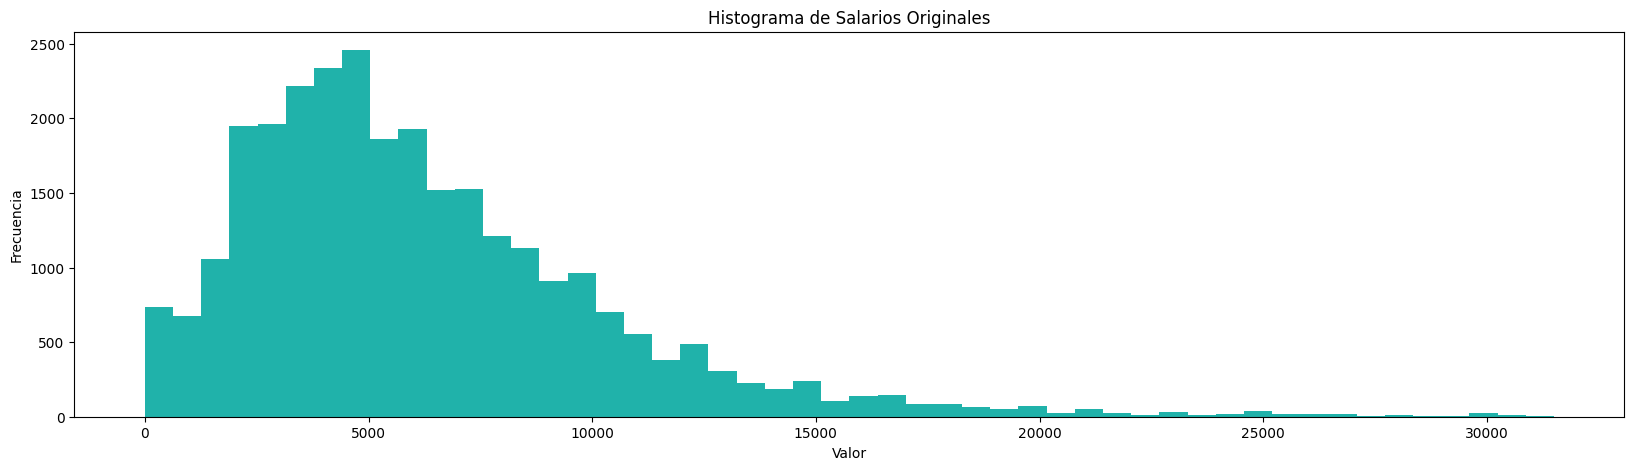

In [ ]:
temporal['latest_salary'].plot.hist(
    bins=50,
    title="Histograma de Salarios Originales",
    figsize=(20, 5),
    color='lightseagreen',
)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.show()

## Imputación
...de salarios nulos por un valor aleatorio de acuerdo a su categorización como pagador:

In [ ]:
# Subconjuntos de salarios por "default_flag"
'''
1. Filtración por malos pagadores (1) y buenos pagadores (0),
2. Selección de salarios que no son nulos, respectivamente
'''
bad = temporal[temporal['default_flag']==1]['latest_salary'][pd.notnull(temporal['latest_salary'])]
good = temporal[temporal['default_flag']==0]['latest_salary'][pd.notnull(temporal['latest_salary'])]

def impute_salary(cols): # Definición de la función "impute_salary" con el argumento "cols":
  salary = cols[0] # Columna 0: se asigna el valor de "latest_salary" a la variable "salary"
  flag = cols[1] # Columna 1: se asigna el valor de "default_flag" a la variable "flag"

  if pd.isnull(salary): # Si el valor de "salary" es nulo, y
    if flag == 1: # Si el valor de "flag" es 1:
      random_value = np.random.choice(bad) # Se elige un valor aleatorio del subconjunto "bad"
      return random_value
# ó
    elif flag == 0: # Si el valor de "flag" es 0:
      random_value = np.random.choice(good) # Se elige un valor aleatorio del subconjunto "good"
      return random_value

  else: # Sino se regresa el salario original
    return salary

In [ ]:
# Copia independiente, cuya manipulación no alaterara los datos originales
imputation = temporal.copy()

In [ ]:
# Aplicación de la imputación a la copia
imputation['latest_salary'] = imputation[['latest_salary','default_flag']].apply(impute_salary, axis=1)

##Comparación
... de valores imputados

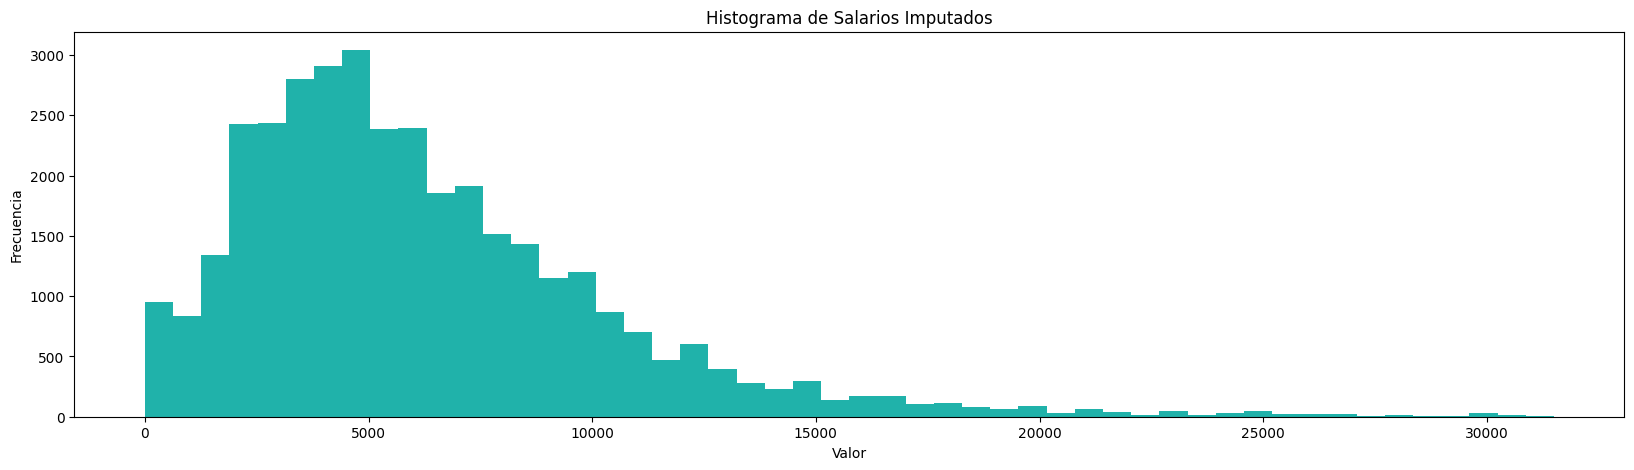

In [ ]:
imputation['latest_salary'].plot.hist(
    bins=50,
    title="Histograma de Salarios Imputados",
    figsize=(20, 5),
    color='lightseagreen',
)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.show()

> Se observa la conservación de la misma distribución, así como un aumento en el eje de frecuencia

In [ ]:
imputation.isna().sum()

user_id                                      0
age                                          0
number_dependents                          942
latest_salary                                0
total_loans                                424
real_estate                                424
others                                     424
more_90_days_overdue                         0
using_lines_not_secured_personal_assets      0
debt_ratio                                   0
default_flag                                 0
dtype: int64

No hay más nulos en la variable "latest_salary"

In [ ]:
imputation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35827 entries, 0 to 35826
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   user_id                                  35827 non-null  Int64  
 1   age                                      35827 non-null  Int64  
 2   number_dependents                        34885 non-null  Int64  
 3   latest_salary                            35827 non-null  int64  
 4   total_loans                              35403 non-null  Int64  
 5   real_estate                              35403 non-null  Int64  
 6   others                                   35403 non-null  Int64  
 7   more_90_days_overdue                     35827 non-null  Int64  
 8   using_lines_not_secured_personal_assets  35827 non-null  float64
 9   debt_ratio                               35827 non-null  float64
 10  default_flag                             35827

In [ ]:
imputation.describe()

,user_id,age,number_dependents,latest_salary,total_loans,real_estate,others,more_90_days_overdue,using_lines_not_secured_personal_assets,debt_ratio,default_flag
count,35827.0,35827.0,34885.0,35827.000000,35403.0,35403.0,35403.0,35827.0,35827.000000,35827.000000,35827.0
mean,18008.639518,52.415608,0.754565,6261.276412,8.566873,1.022343,7.54453,0.261842,5.641768,353.268147,0.019064
std,10394.475712,14.802143,1.115744,4217.777318,5.106007,1.104471,4.741861,4.131237,220.985315,2016.338742,0.136751
min,1.0,21.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,9005.5,41.0,0.0,3365.000000,5.0,0.0,4.0,0.0,0.029488,0.178055,0.0
50%,18013.0,52.0,0.0,5388.000000,8.0,1.0,7.0,0.0,0.149616,0.368007,0.0
75%,27012.5,63.0,1.0,8200.000000,11.0,2.0,10.0,0.0,0.548814,0.883020,0.0
max,36000.0,98.0,13.0,31500.000000,53.0,20.0,52.0,98.0,22000.000000,307001.000000,1.0


> La media y desviación estandár aumentan ligeramente, así como incrementa la sumatoria

In [ ]:
mediana_salary = imputation['latest_salary'].median()

print(f"Mediana de 'latest_salary' con los valores imputados: {mediana_salary}")

Mediana de 'latest_salary' con los valores imputados: 5388.0


> La mediana prácticamente se conserva

## Histogramas

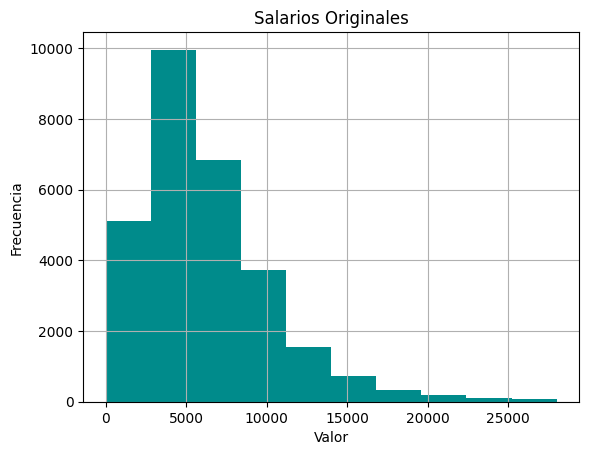

In [ ]:
temporal['latest_salary'].hist(range=(0, 28000),color='darkcyan')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Salarios Originales')

plt.show()

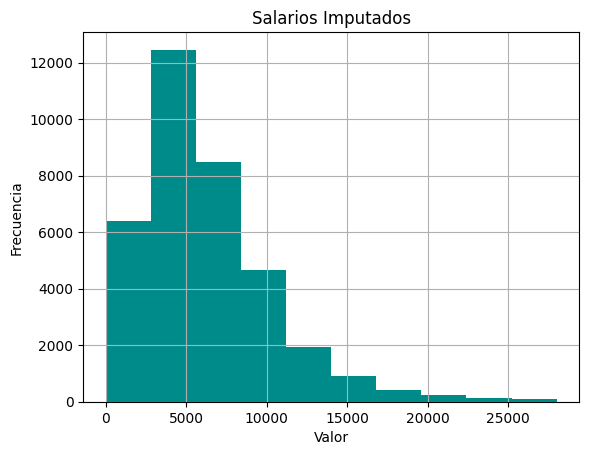

In [ ]:
imputation['latest_salary'].hist(range=(0, 28000), color='darkcyan')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Salarios Imputados')

plt.show()

## Boxplot

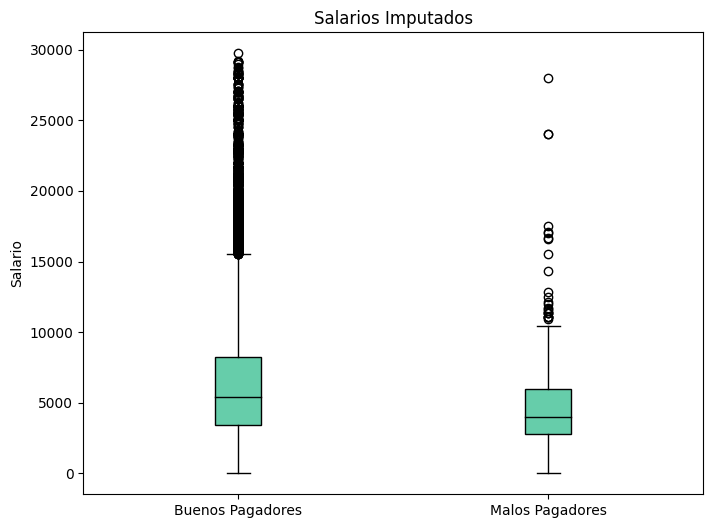

In [ ]:
# Distribución de buenos y malos pagadores
'''
1. Filtración por "default_flag,"
& condición de valor límite (a 30,000 en vez de 28,000 p/que se aprecie extremo mal pagador),
2. Selección de la variable "latest_salary"
'''
buenos_pagadores = imputation[(imputation['default_flag'] == 0) & (imputation['latest_salary'] < 30000)]['latest_salary']
malos_pagadores = imputation[(imputation['default_flag'] == 1) & (imputation['latest_salary'] < 30000)]['latest_salary']

plt.figure(figsize=(8, 6))
plt.boxplot([buenos_pagadores, malos_pagadores], patch_artist=True, boxprops=dict(facecolor='mediumaquamarine'), medianprops=dict(color='black'))
plt.xticks([1, 2], ['Buenos Pagadores', 'Malos Pagadores'])
plt.ylabel('Salario')
plt.title('Salarios Imputados')

plt.show()


In [ ]:
#Descarga de tabla actualizada
imputation.to_csv('post_users.csv', index=False)

FIN

# Master

Tabla master con eliminacione e imputaciones



In [ ]:
query = """
SELECT * EXCEPT (user_id)
FROM proyecto-no3-riesgos.dataset.final
"""

query_job = client.query(query)
final = query_job.to_dataframe()

In [ ]:
final.shape

(35827, 10)

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35827 entries, 0 to 35826
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               35827 non-null  Int64  
 1   dependents_new    35827 non-null  Int64  
 2   latest_salary     35827 non-null  Int64  
 3   total_loans_new   35827 non-null  Int64  
 4   real_estate_new   35827 non-null  Int64  
 5   others_new        35827 non-null  Int64  
 6   overdue_90_days   35827 non-null  Int64  
 7   credit_lines_new  35827 non-null  float64
 8   debt_ratio_new    35827 non-null  float64
 9   default_flag      35827 non-null  Int64  
dtypes: Int64(8), float64(2)
memory usage: 3.0 MB


In [ ]:
final.describe()

,age,dependents_new,latest_salary,total_loans_new,real_estate_new,others_new,overdue_90_days,credit_lines_new,debt_ratio_new,default_flag
count,35827.0,35827.0,35827.0,35827.0,35827.0,35827.0,35827.0,35827.000000,35827.000000,35827.0
mean,52.415608,0.734725,6261.276412,8.465487,1.010244,7.455243,0.115946,0.315638,0.468756,0.019064
std,14.802143,1.107578,4217.777318,5.15956,1.103468,4.783806,0.800065,0.347382,0.355544,0.136751
min,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,41.0,0.0,3365.0,5.0,0.0,4.0,0.0,0.029488,0.178055,0.0
50%,52.0,0.0,5388.0,8.0,1.0,7.0,0.0,0.149616,0.368007,0.0
75%,63.0,1.0,8200.0,11.0,2.0,10.0,0.0,0.548814,0.883020,0.0
max,98.0,13.0,31500.0,53.0,20.0,52.0,15.0,1.000000,1.000000,1.0


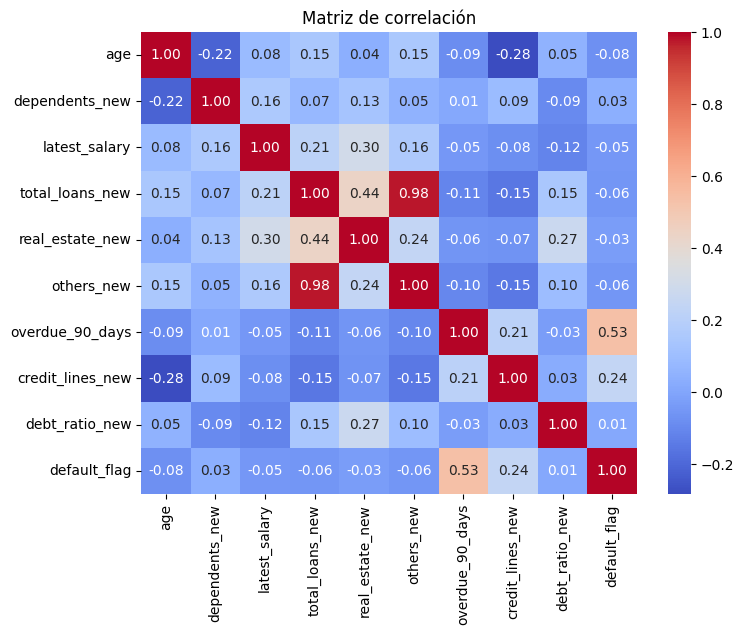

In [ ]:
correlation_matrix = final.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()